<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Visual-RF-with-Coloring" data-toc-modified-id="Visual-RF-with-Coloring-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Visual RF with Coloring</a></span><ul class="toc-item"><li><span><a href="#Imports-and-Setup" data-toc-modified-id="Imports-and-Setup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports and Setup</a></span></li><li><span><a href="#Generate-Data" data-toc-modified-id="Generate-Data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate Data</a></span></li><li><span><a href="#Training-a-Single-Tree" data-toc-modified-id="Training-a-Single-Tree-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Training a Single Tree</a></span></li><li><span><a href="#Predicting-with-One-Tree" data-toc-modified-id="Predicting-with-One-Tree-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Predicting with One Tree</a></span></li><li><span><a href="#Training-a-Forest" data-toc-modified-id="Training-a-Forest-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Training a Forest</a></span></li><li><span><a href="#Predicting-with-a-Forest" data-toc-modified-id="Predicting-with-a-Forest-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Predicting with a Forest</a></span></li></ul></li></ul></div>

# Visual RF with Coloring

## Imports and Setup

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.utils.extmath import cartesian

sns.set()

In [2]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [3]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs], self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs], self.min_leaf)

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.
        for i in range(self.min_leaf, self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score:
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [4]:
def plot_splits(tree, wll, wur, depth = 1, max_depth = 300, show_val = False):
    if max_depth < depth or tree.is_leaf:
        if show_val:
            plt.text((wll[0] + wur[0]) / 2 - (wur[0] - wll[0]) / 2.2, (wll[1] + wur[1]) / 2, 
                     f'value: {round(tree.val, 2)}\n# in partition: {len(tree.idxs)}')
        return
    
    feature = tree.split_name
    thresh = tree.split
    
    if feature == 'x':
        plt.vlines([thresh], wll[1], wur[1])
        plot_splits(tree.lhs, wll, (thresh, wur[1]), depth + 1, max_depth, show_val)
        plot_splits(tree.rhs, (thresh, wll[1]), wur, depth + 1, max_depth, show_val)
        
    else:
        plt.hlines([thresh], wll[0], wur[0])
        plot_splits(tree.lhs, wll, (wur[0], thresh), depth + 1, max_depth, show_val)
        plot_splits(tree.rhs, (wll[0], thresh) , wur, depth + 1, max_depth, show_val)

## Generate Data

In [5]:
n = 1000
x = np.random.uniform(0, 1, n)
y = np.random.uniform(0, 1, n)
target = norm.pdf((x - 0.75) / 0.1) + norm.pdf((y - 0.75) / 0.1) \
        + norm.pdf((x - 0.25) / 0.1) + norm.pdf((y - 0.25) / 0.1) \
        + np.array(np.round(np.random.normal(-0.1,0.1, n), 2))

## Training a Single Tree

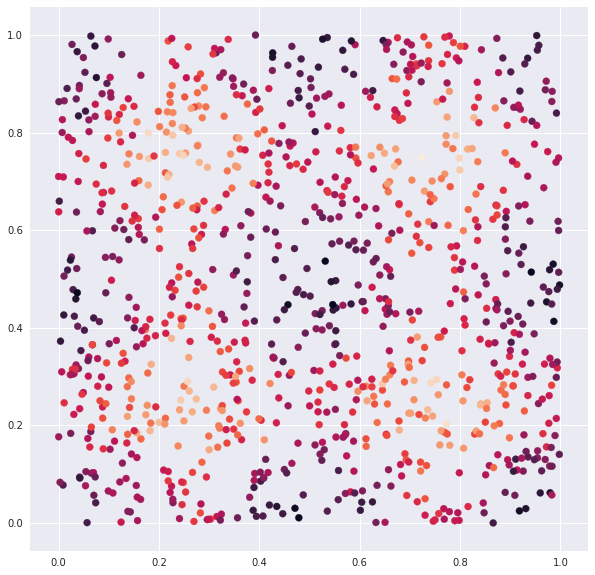

In [6]:
# Plot all points
fig, ax = plt.subplots(figsize = (10,10))
ax.scatter(x, y, c = target)

In [7]:
data1 = pd.DataFrame({'x' : x, 'y' : y})
rf_model_1 = TreeEnsemble(data1, target, n_trees = 1, sample_sz=n, min_leaf=8)
tree_1 = rf_model_1.trees[0]

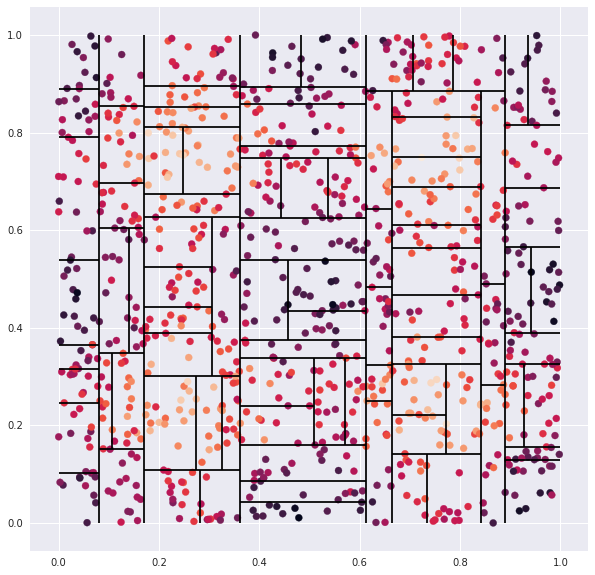

In [8]:
plt.figure(figsize = (10,10))
plt.scatter(x, y, c = target)

plot_splits(tree_1, (0,0), (1, 1))

In [9]:
color = rf_model_1.predict(points)

plt.figure(figsize=(10,10))
plt.grid(False)
plt.imshow(color.reshape(w,w), origin = 'lower', extent=[0,1,0,1])
plot_splits(tree_1, (0,0), (1, 1))

NameError: name 'points' is not defined

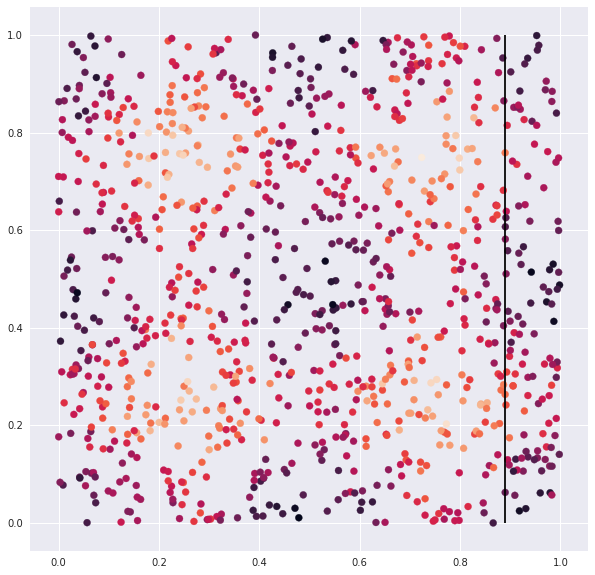

In [10]:
plt.figure(figsize = (10,10))
plt.scatter(x, y, c = target)

plot_splits(tree_1, (0,0), (1, 1), max_depth=1)

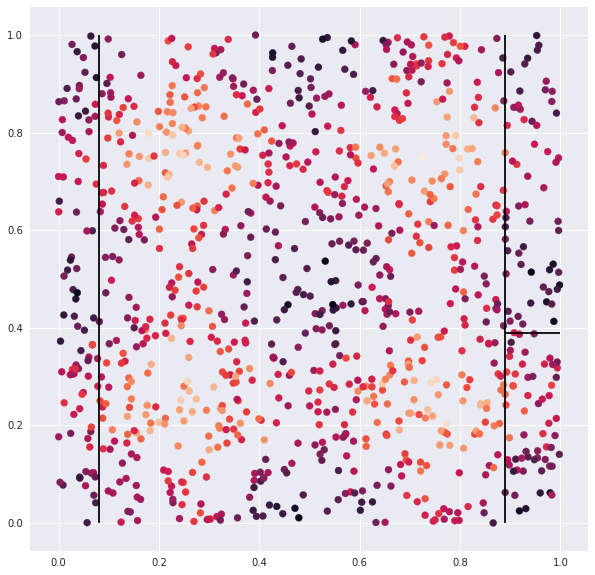

In [11]:
plt.figure(figsize = (10,10))
plt.scatter(x, y, c = target)

plot_splits(tree_1, (0,0), (1, 1), max_depth=2)

## Predicting with One Tree

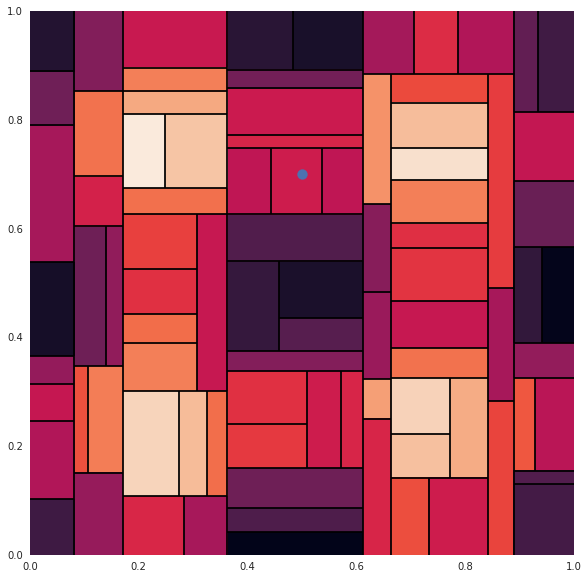

In [12]:
w = 512
nx = np.linspace(0,1,w)
ny = np.linspace(0,1,w)

points = np.array([[x, y] for y in ny for x in nx])

color = rf_model_1.predict(points)

plt.figure(figsize=(10,10))
plt.grid(False)
plt.imshow(color.reshape(w,w), origin = 'lower', extent=[0,1,0,1])
plot_splits(tree_1, (0,0), (1, 1))

plt.scatter(0.5, 0.7, s=100)

## Training a Forest

In [13]:
rf_model_2 = TreeEnsemble(data1, target, n_trees = 4, sample_sz= int(n *.5))
trees_2 = rf_model_2.trees

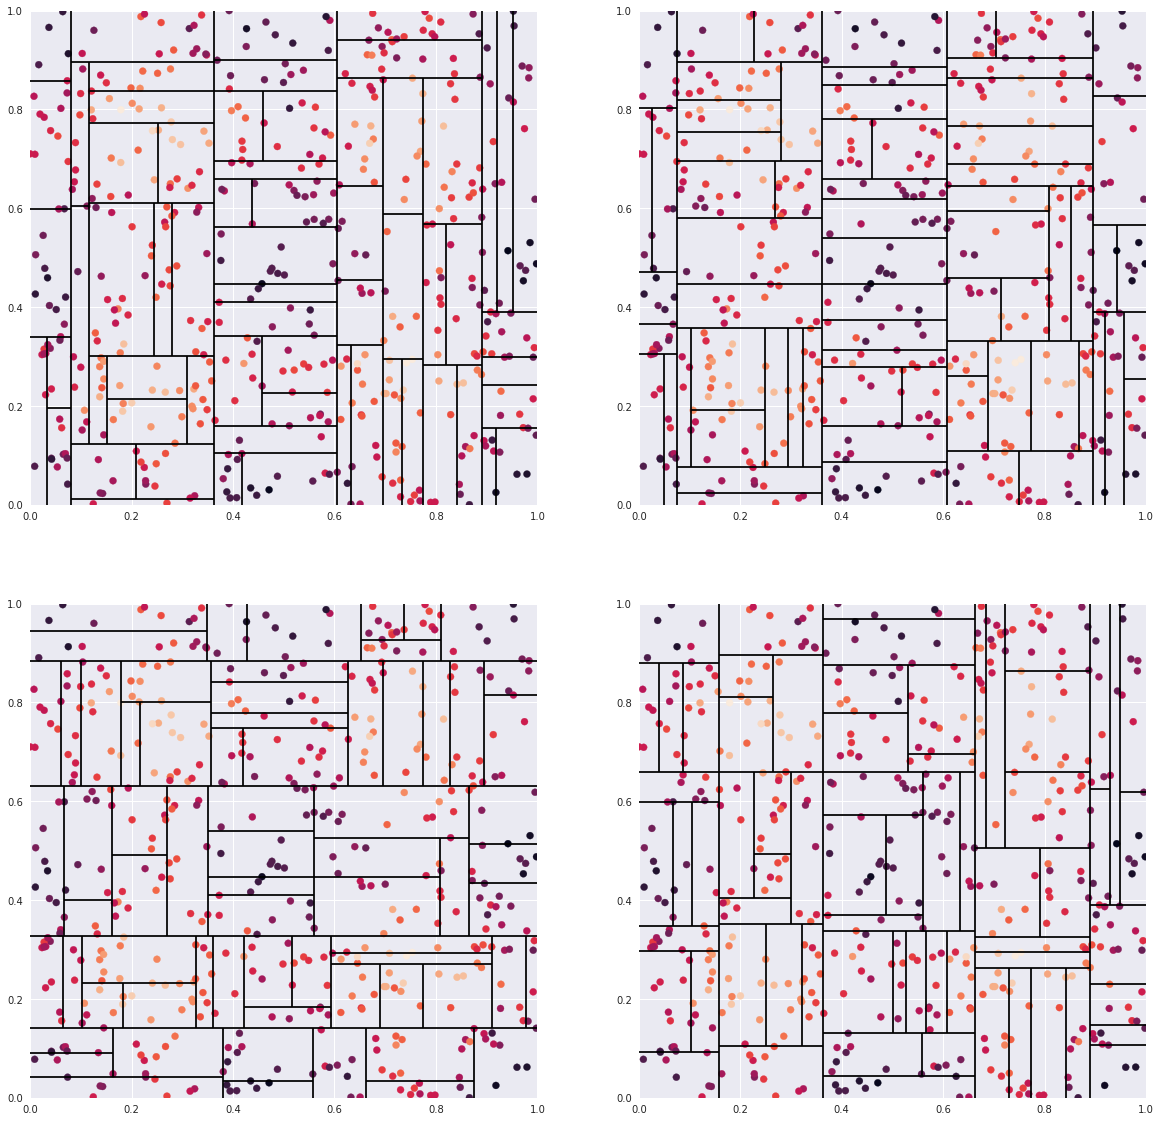

In [14]:
plt.figure(figsize = (20,20))

i = 1
for t in trees_2:
    plt.subplot(2, 2, i)
    
    plt.scatter(x[t.idxs], y[t.idxs], c = target[t.idxs])
    plt.xlim((0,1))
    plt.ylim((0,1))
    plot_splits(t, (0,0), (1, 1))
    i = i + 1

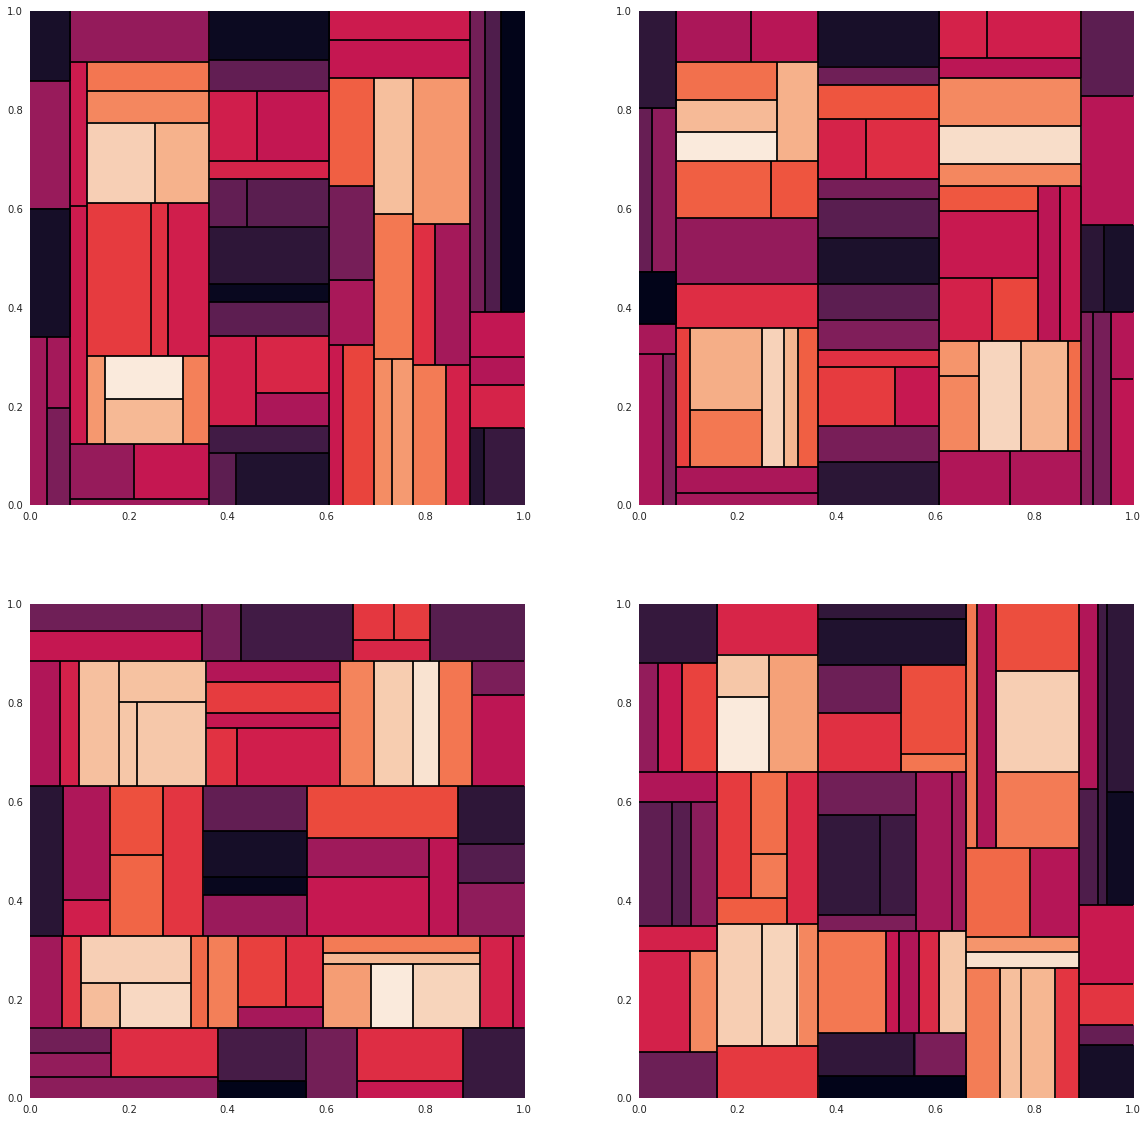

In [15]:
plt.figure(figsize = (20,20))

i = 1
for t in trees_2:
    plt.subplot(2, 2, i)
    color = t.predict(points)

    plt.grid(False)
    plt.imshow(color.reshape(w,w), origin = 'lower', extent=[0,1,0,1])
    plot_splits(t, (0,0), (1, 1))

    i = i + 1

## Predicting with a Forest

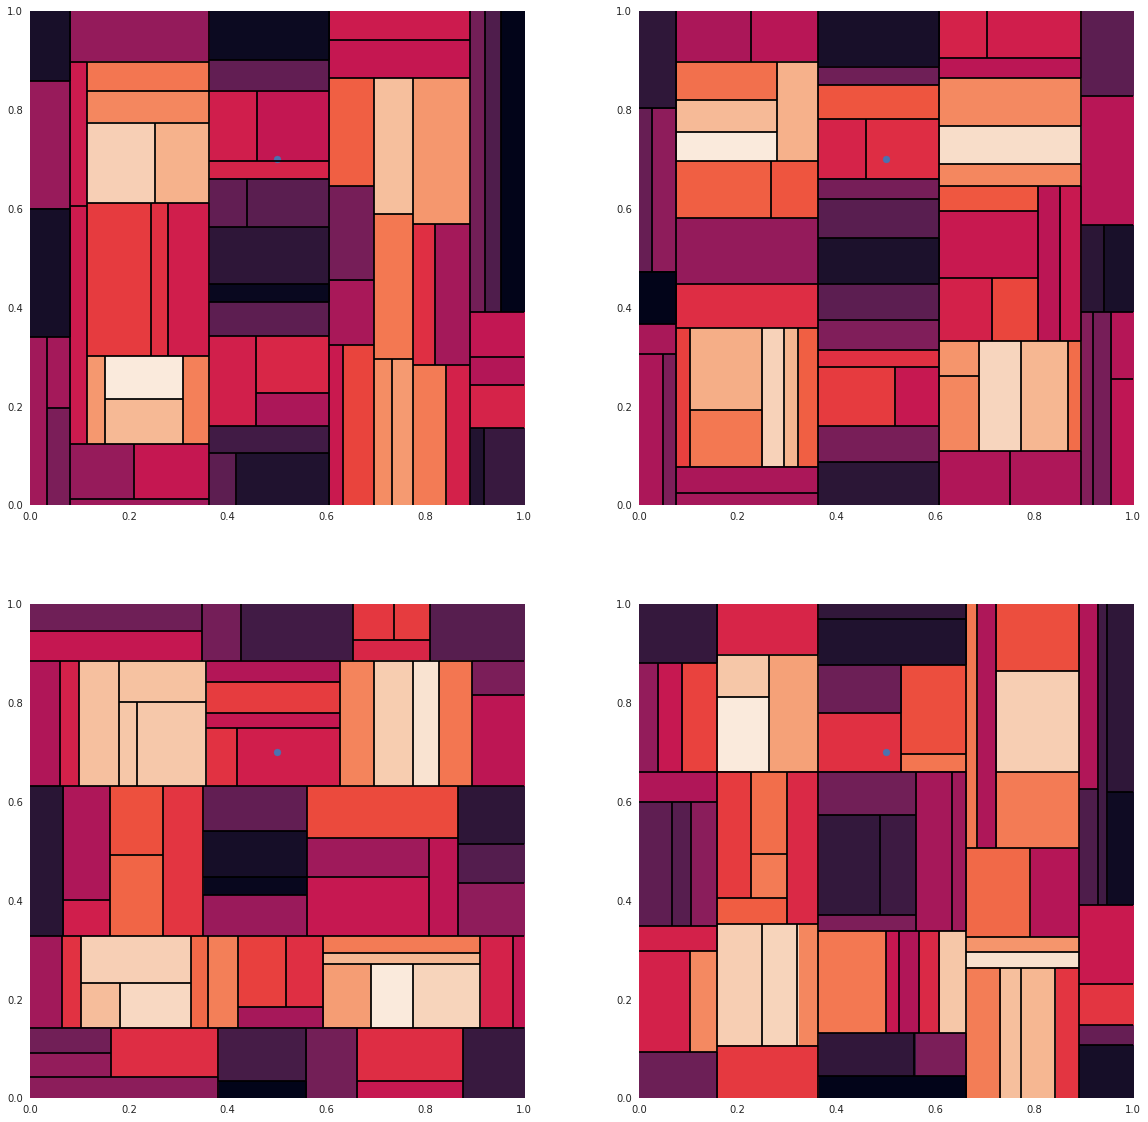

In [16]:
plt.figure(figsize = (20,20))

i = 1
for t in trees_2:
    plt.subplot(2, 2, i)
    
    color = t.predict(points)
    
    plt.grid(False)
    plt.imshow(color.reshape(w,w), origin = 'lower', extent=[0,1,0,1])
    plot_splits(t, (0,0), (1, 1))
    plt.scatter(0.5, 0.7)    
    i = i + 1

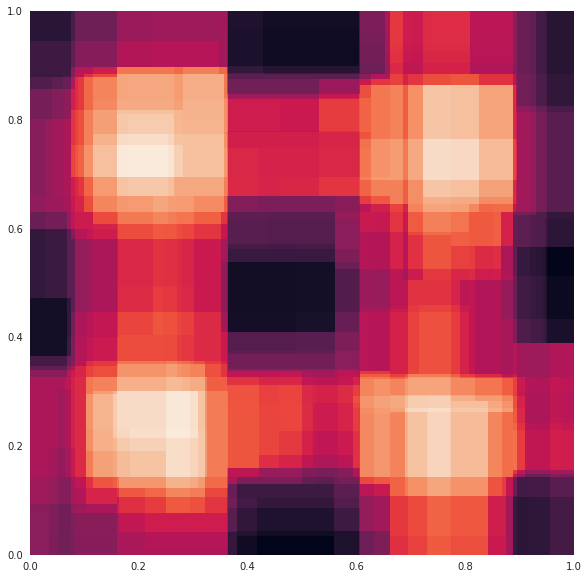

In [17]:
color = rf_model_2.predict(points)

plt.figure(figsize=(10,10))
plt.grid(False)
plt.imshow(color.reshape(w,w), origin = 'lower', extent=[0,1,0,1])

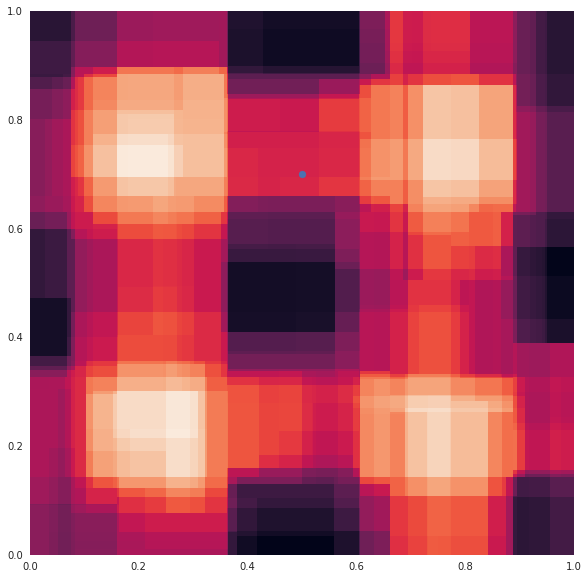

In [18]:
color = rf_model_2.predict(points)

plt.figure(figsize=(10,10))
plt.grid(False)
plt.imshow(color.reshape(w,w), origin = 'lower', extent=[0,1,0,1])
plt.scatter(0.5, 0.7)